<center>
<img src="images/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
Авторы материала: Юрий Кашницкий (@yorko) и Максим Уваров (@maxis42). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3 
## <center> Деревья решений для классификации и регрессии

**В этом задании мы разберемся с тем, как работает дерево решений в задаче регрессии, а также построим (и настроим) классифицирующие деревья решений в задаче прогнозирования сердечно-сосудистых заболеваний. 
Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1bXgaJRh4naJOGzE_Li2k50TN0kOPJdNhMtHl6H4t3Lk/edit).**

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз ([4-я статья курса](https://habrahabr.ru/company/ods/blog/323890/)), а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно прочитайте небольшой раздел ["Дерево решений в задаче регрессии"](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii) 3-ей статьи курса. 

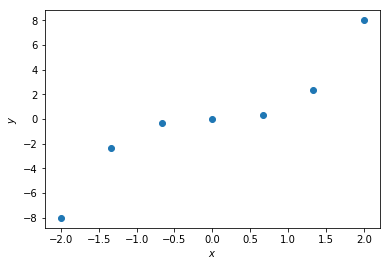

In [2]:
X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график. Тут без `sklearn` – разбираемся просто с ручкой, бумажкой и Python, если надо.

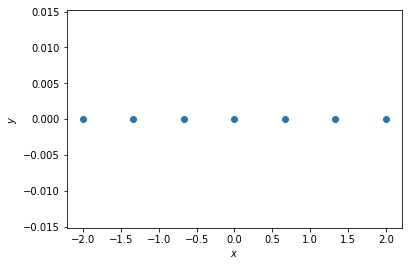

In [3]:
a = X.mean() * np.ones_like(y)

plt.scatter(X, a)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

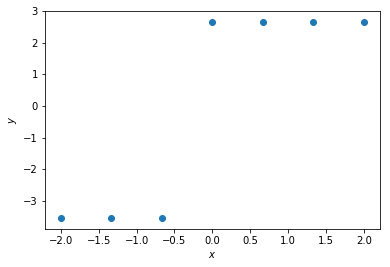

In [4]:
a = np.where(X < 0, y[X < 0].mean(), y[X >= 0].mean())

plt.scatter(X, a)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), $|X|$, $|X_l|$, $|X_r|$ - размеры соответствующих выборок, а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [5]:
def regression_var_criterion(X, y, t):
    yl = y[X < t]
    yr = y[X >= t]
    return (y.var() - yl.shape[0] / y.shape[0] * yl.var() - yr.shape[0] / y.shape[0] * yr.var()) / y.shape[0]

regression_var_criterion_vec = np.vectorize(regression_var_criterion, excluded=[0, 1])

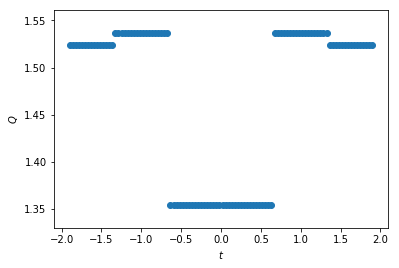

In [6]:
t = np.linspace(-1.9, 1.9, 100, endpoint=True)
Q = regression_var_criterion_vec(X, y, t)

plt.scatter(t, Q)
plt.xlabel(r'$t$')
plt.ylabel(r'$Q$');

**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- Да
- Нет

__Нет__

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

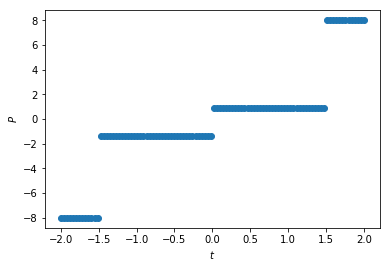

In [7]:
def predict(X, y, p):
    if p < -1.5:
        return y[X < -1.5].mean()
    elif p < 0:
        return y[(X >= -1.5) & (X < 0)].mean()
    elif p < 1.5:
        return y[(X >= 0) & (X < 1.5)].mean()
    else:
        return y[X >= 1.5].mean()

predict_vec = np.vectorize(predict, excluded=[0, 1])

P = np.linspace(-2, 2, 100, endpoint=True)

t = predict_vec(X, y, P)

plt.scatter(P, t)
plt.xlabel(r'$t$')
plt.ylabel(r'$P$');

**<font color='red'>Вопрос 2.</font> Из какого числа отрезков состоит график (необходимо считать как горизонтальные, так и вертикальные прямые), изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 5
- 6
- 7
- 8

__7__

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [8]:
df = pd.read_csv('data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [9]:
df.head()

age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
id                                                                          
0   18393       2     168    62.0    110     80            1     1      0   
1   20228       1     156    85.0    140     90            3     1      0   
2   18857       1     165    64.0    130     70            3     1      0   
3   17623       2     169    82.0    150    100            1     1      0   
4   17474       1     156    56.0    100     60            1     1      0   

    alco  active  cardio  
id                        
0      0       1       0  
1      0       1       1  
2      0       0       1  
3      0       1       1  
4      0       0       0

Сделайте небольшие преобразования признаков: постройте признак "возраст в годах" (полных лет), а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`. Исходные признаки `cholesterol` и `gluc` после кодирования использовать не нужно.

In [10]:
df['years'] = df.age // 365.25
df = pd.concat([df, pd.get_dummies(df.cholesterol, prefix='cholesterol')], axis=1)
df = pd.concat([df, pd.get_dummies(df.gluc, prefix='gluc')], axis=1)
df.tail()

age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
id                                                                             
99993  19240       2     168    76.0    120     80            1     1      1   
99995  22601       1     158   126.0    140     90            2     2      0   
99996  19066       2     183   105.0    180     90            3     1      0   
99998  22431       1     163    72.0    135     80            1     2      0   
99999  20540       1     170    72.0    120     80            2     1      0   

       alco  active  cardio  years  cholesterol_1  cholesterol_2  \
id                                                                 
99993     0       1       0     52              1              0   
99995     0       1       1     61              0              1   
99996     1       0       1     52              0              0   
99998     0       0       1     61              1              0   
99999     0       1       0     56              0              1   

       cholesterol_3  gluc_1  gluc_2  gluc_3  
id                                            
99993              0       1       0       0  
99995              0       0       1       0  
99996              1       1       0       0  
99998              0       0       1       0  
99999              0       1       0       0

Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(df.drop('cardio', axis=1), df['cardio'], test_size=0.3, random_state=17)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((49000, 18), (21000, 18), (49000,), (21000,))

Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/) под спойлером "Код для отрисовки дерева". Названия файлов писать без кавычек, для того чтобы работало в jupyter notebook. Обратите внимание, что команды в Jupyter notebook, начинающиеся с восклицательного знака – это терминальные команды (которые мы обычно запускаем в терминале/командной строке).

In [12]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=3, random_state=17)
tree.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=17, splitter='best')

In [13]:
export_graphviz(tree, feature_names=df.drop('cardio', axis=1).columns, out_file='images/churn_tree.dot', filled=True)
!dot -Tpng 'images/churn_tree.dot' -o 'images/churn_tree.png'

|

**<font color='red'>Вопрос 3.</font> Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- age, ap_hi, chol=3

__Age, ap_hi & cholesterol_3__

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_valid, y_valid)`. Посчитайте долю верных ответов (accuracy).

In [14]:
from sklearn.metrics import accuracy_score

t_valid = tree.predict(X_valid) > 0.5
accuracy_depth_3 = accuracy_score(y_valid, t_valid)
accuracy_depth_3

0.7212857142857143

Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте GridSearchCV, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [15]:
from sklearn.model_selection import GridSearchCV, cross_val_score

tree_params = {'max_depth': list(range(2, 11))}

tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True)

tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.2s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=17, splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

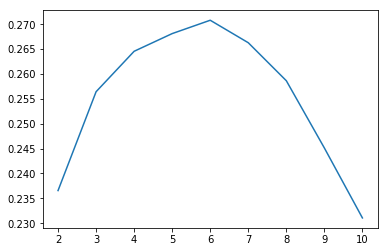

In [16]:
depth = np.arange(2, 11)
accuracy = tree_grid.cv_results_['mean_test_score']

plt.plot(depth, accuracy)

Выведите лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

In [17]:
tree_grid.best_params_

{'max_depth': 6}

In [18]:
t_valid = tree_grid.predict(X_valid) > 0.5
accuracy_depth_max = accuracy_score(y_valid, t_valid)
accuracy_depth_max

0.7258571428571429

In [19]:
accuracy_depth_3, accuracy_depth_max

(0.7212857142857143, 0.7258571428571429)

In [20]:
(accuracy_depth_max - accuracy_depth_3) / accuracy_depth_3 * 100

0.633788869082985

**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева пик `accuracy`, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке (надо посмотреть на выражение (acc2 - acc1) / acc1 * 100%, где acc1 и acc2 – доли верных ответов на отложенной выборке до и после настройки max_depth соответственно)?**
- да, да
- да, нет
- нет, да
- нет, нет

__Да (6), нет (0.6%)__

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='images/SCORE2007.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50), \ldots age \in [60,65) $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)

Если значение возраста или артериального давления не попадает ни в один из интервалов, то все бинарные признаки будут равны нулю. Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках (исходные признаки не берем).

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**
- Верхнее артериальное давление от 160 до 180 (мм рт.ст.)
- Пол мужской / женский
- Верхнее артериальное давление от 140 до 160 (мм рт.ст.)
- Возраст от 50 до 55 (лет)
- Курит / не курит
- Возраст от 60 до 65 (лет)

In [21]:
df.head()

age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
id                                                                          
0   18393       2     168    62.0    110     80            1     1      0   
1   20228       1     156    85.0    140     90            3     1      0   
2   18857       1     165    64.0    130     70            3     1      0   
3   17623       2     169    82.0    150    100            1     1      0   
4   17474       1     156    56.0    100     60            1     1      0   

    alco  active  cardio  years  cholesterol_1  cholesterol_2  cholesterol_3  \
id                                                                             
0      0       1       0     50              1              0              0   
1      0       1       1     55              0              0              1   
2      0       0       1     51              0              0              1   
3      0       1       1     48              1              0              0   
4      0       0       0     47              1              0              0   

    gluc_1  gluc_2  gluc_3  
id                          
0        1       0       0  
1        1       0       0  
2        1       0       0  
3        1       0       0  
4        1       0       0

In [22]:
df.gender = df.gender - 1
df = df.rename(index=str, columns={"gender": "male"})

In [23]:
df['years_45_49'] = np.where((df.years >= 45) & (df.years <= 49), 1, 0)
df['years_50_54'] = np.where((df.years >= 50) & (df.years <= 54), 1, 0)
df['years_55_59'] = np.where((df.years >= 55) & (df.years <= 59), 1, 0)
df['years_60_64'] = np.where((df.years >= 60) & (df.years <= 64), 1, 0)

In [24]:
df['ap_hi_120_139'] = np.where((df.ap_hi >= 120) & (df.ap_hi <= 139), 1, 0)
df['ap_hi_140_159'] = np.where((df.ap_hi >= 140) & (df.ap_hi <= 159), 1, 0)
df['ap_hi_160_179'] = np.where((df.ap_hi >= 160) & (df.ap_hi <= 179), 1, 0)

In [25]:
usefull = ['male', 'smoke',
           'years_45_49', 'years_50_54', 'years_55_59', 'years_60_64',
           'ap_hi_120_139', 'ap_hi_140_159', 'ap_hi_160_179',
           'cholesterol_1', 'cholesterol_2', 'cholesterol_3']
X = df[usefull]
y = df['cardio']
X.head()

male  smoke  years_45_49  years_50_54  years_55_59  years_60_64  \
id                                                                    
0      1      0            0            1            0            0   
1      0      0            0            0            1            0   
2      0      0            0            1            0            0   
3      1      0            1            0            0            0   
4      0      0            1            0            0            0   

    ap_hi_120_139  ap_hi_140_159  ap_hi_160_179  cholesterol_1  cholesterol_2  \
id                                                                              
0               0              0              0              1              0   
1               0              1              0              0              0   
2               1              0              0              0              0   
3               0              1              0              1              0   
4               0              0              0              1              0   

    cholesterol_3  
id                 
0               0  
1               1  
2               1  
3               0  
4               0

In [26]:
tree = DecisionTreeRegressor(max_depth=3, random_state=17)
tree.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=17, splitter='best')

In [27]:
export_graphviz(tree, feature_names=X.columns, out_file='images/churn_tree_2.dot', filled=True)
!dot -Tpng 'images/churn_tree_2.dot' -o 'images/churn_tree_2.png'

<img src="images/churn_tree_2.png">

__Верхнее артериальное давление от 140 до 160 (мм рт.ст.)__